# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [122]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

In [ ]:
#use this cell to import additional libraries or define helper functions
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import keras



## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [124]:
# Load the data
df = pd.read_csv('C:\\Users\\jegullin\\Downloads\\data-module4\\household_power_clean.csv')
df.head()

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,NaN,NaN,NaN,NaN
1,1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,NaN,NaN,NaN,NaN
2,2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,NaN,NaN,NaN,NaN
3,3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,NaN,NaN,NaN,NaN
4,4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,NaN,NaN,NaN,NaN


In [125]:
df.describe()

,Unnamed: 0,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,gap_monthly,grp_monthly,v_monthly,gi_monthly
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049251e+06,2.049251e+06,2.049251e+06,2.049251e+06
mean,1.031496e+06,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00,1.091592e+00,1.237133e-01,2.408399e+02,4.627662e+00
std,5.964586e+05,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00,9.516172e-01,7.736539e-02,3.080626e+00,3.987975e+00
min,0.000000e+00,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,8.166667e-02,0.000000e+00,2.255873e+02,2.200000e-01
25%,5.162538e+05,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.301333e-01,6.960000e-02,2.391050e+02,1.460000e+00
50%,1.028638e+06,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,7.143333e-01,1.030000e-01,2.409840e+02,3.073333e+00
75%,1.545307e+06,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,1.569933e+00,1.593333e-01,2.427670e+02,6.560000e+00
max,2.075258e+06,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,7.966200e+00,7.897333e-01,2.524423e+02,3.423333e+01


In [126]:
# Drop the date column
df = df.drop(columns=['Unnamed: 0'])

In [127]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,NaN,NaN,NaN,NaN
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,NaN,NaN,NaN,NaN
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,NaN,NaN,NaN,NaN
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,NaN,NaN,NaN,NaN
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,NaN,NaN,NaN,NaN


In [128]:
# Take the few data points for training
df_size = round(len(df)/100)

# randomly select a start index
start = np.random.choice(range(0, len(df)-df_size))
df_small = df.iloc[start:start+df_size].reset_index()
 
# Split the data into training and validation sets
split_point = round(len(df_small)*0.8)
train_df = df_small.iloc[:split_point]
val_df = df_small.iloc[split_point:]

In [129]:
#Reset the index
train_df = train_df.reset_index()
val_df = val_df.reset_index()

In [130]:
train_df.head()

,level_0,index,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,0,486191,2007-11-22,02:08:00,0.226,0.000,246.98,1.0,0.0,0.0,0.0,2007-11-22 02:08:00,0.281667,0.061067,243.657000,1.186667
1,1,486192,2007-11-22,02:09:00,0.248,0.000,246.72,1.2,0.0,0.0,0.0,2007-11-22 02:09:00,0.279467,0.057933,243.828667,1.180000
2,2,486193,2007-11-22,02:10:00,0.306,0.084,247.18,1.2,0.0,0.0,0.0,2007-11-22 02:10:00,0.279200,0.057533,244.002333,1.173333
3,3,486194,2007-11-22,02:11:00,0.306,0.086,247.88,1.2,0.0,0.0,0.0,2007-11-22 02:11:00,0.278933,0.057200,244.191000,1.166667
4,4,486195,2007-11-22,02:12:00,0.306,0.084,247.63,1.2,0.0,0.0,0.0,2007-11-22 02:12:00,0.278667,0.056867,244.383333,1.160000


Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [131]:
seq_arrays = []
seq_labs = []

In [132]:
# Sequence length and prediction horizon
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings
for start in range(0, len(train_df) - seq_length - ph):
    end = start + seq_length
    seq_arrays.append(train_df[feat_cols].iloc[start:end].values)
    seq_labs.append(train_df[feat_cols].iloc[end + ph - 1].values)


#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [133]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,1))

In [134]:
seq_arrays.shape

(16359, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: The assert statements in the above cell are used to verify that the shapes of the seq_arrays and seq_labs numpy arrays are as expected. Assertions are used in code to ensure that certain conditions hold true during execution. If an assertion fails, it raises an AssertionError, which helps in identifying issues early in the development process

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [135]:
# Define path to save model
model_path = 'LSTM_model1-eval.keras'

# Build the network
nb_features = len(feat_cols)
nb_out = 1

# Model architecture
model = Sequential()

# Add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5, 
         return_sequences=True))
model.add(Dropout(0.2)) 

# Add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))

# Add final Dense layer
model.add(Dense(units=nb_out))
model.add(Activation('linear'))

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model.summary())

# Fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                     keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# List all data in history
print(history.history.keys())

C:\Users\jegullin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 30, 5)          │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 30, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 3)              │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 79s - 2s/step - loss: 2.0769 - mse: 2.1260 - val_loss: 0.3888 - val_mse: 0.3210
Epoch 2/100
32/32 - 5s - 159ms/step - loss: 0.9269 - mse: 0.9440 - val_loss: 0.3123 - val_mse: 0.2577
Epoch 3/100
32/32 - 1s - 43ms/step - loss: 0.7116 - mse: 0.7185 - val_loss: 0.2938 - val_mse: 0.2431
Epoch 4/100
32/32 - 2s - 66ms/step - loss: 0.6502 - mse: 0.6476 - val_loss: 0.2831 - val_mse: 0.2340
Epoch 5/100
32/32 - 1s - 31ms/step - loss: 0.6156 - mse: 0.6143 - val_loss: 0.2838 - val_mse: 0.2361
Epoch 6/100
32/32 - 1s - 31ms/step - loss: 0.5699 - mse: 0.5763 - val_loss: 0.2782 - val_mse: 0.2306
Epoch 7/100
32/32 - 1s - 28ms/step - loss: 0.5724 - mse: 0.5767 - val_loss: 0.2908 - val_mse: 0.2360
Epoch 8/100
32/32 - 1s - 30ms/step - loss: 0.5644 - mse: 0.5741 - val_loss: 0.2689 - val_mse: 0.2228
Epoch 9/100
32/32 - 1s - 29ms/step - loss: 0.5627 - mse: 0.5643 - val_loss: 0.2693 - val_mse: 0.2213
Epoch 10/100
32/32 - 1s - 32ms/step - loss: 0.5365 - mse: 0.5415 - val_loss: 0.2628 - 

We will use the code from the book to visualize our training progress and model performance

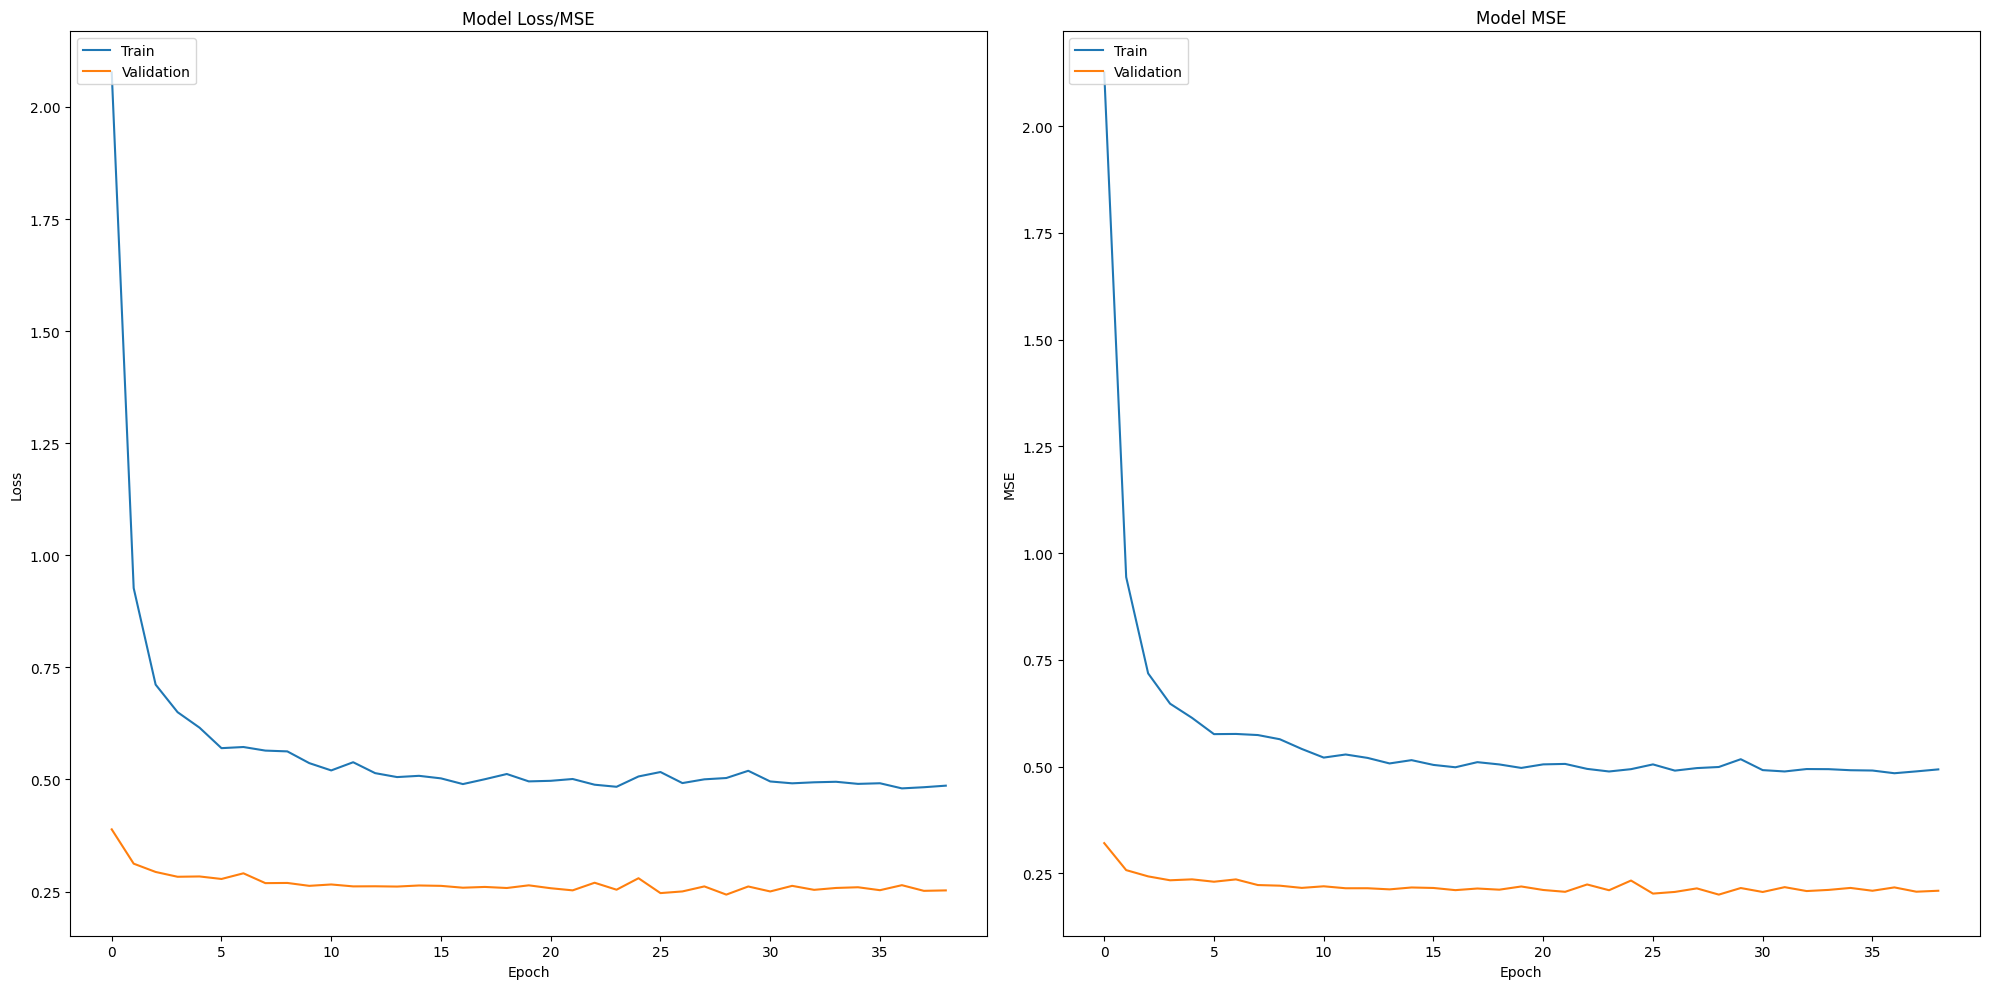

In [136]:
#Subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Summarize history for Loss
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Model Loss/MSE')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Summarize history for MSE
axes[1].plot(history.history['mse'])
axes[1].plot(history.history['val_mse'])
axes[1].set_title('Model MSE')
axes[1].set_ylabel('MSE')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: The `pad_sequences` function in Keras is used to ensure that all sequences in a list have the same length. This is particularly useful when dealing with sequences of variable lengths, as many machine learning models, including LSTMs, require inputs of uniform length. It adds dummy values to the beginning or end of the sequences to make them all the same length. The `padding` argument determines whether the padding should be added to the beginning or end of the sequences, and the setting that makes the most sense for our use case here is `pre`, as we want to add padding to the beginning of the sequences to ensure that they all have the same length.


In [138]:
val_arrays = []
val_labs = []

# We'll start out with a 30 minute input sequence and a 5 minute predictive horizon
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

# Create list of GAP readings starting with a minimum of two readings
for start in range(0, len(val_df) - seq_length - ph):
    end = start + seq_length
    val_arrays.append(val_df[feat_cols].iloc[start:end].values)
    val_labs.append(val_df[feat_cols].iloc[end + ph - 1].values)

# Use the pad_sequences function on your input sequences
# Remember that we will later want our datatype to be np.float32 
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype='float32', padding='pre')

# Convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype=object).astype(np.float32)

print(f'Shape of val_arrays: {val_arrays.shape}')
print(f'Shape of val_labs: {val_labs.shape}')

Shape of val_arrays: (4064, 30, 1)
Shape of val_labs: (4064, 1)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

127/127 - 1s - 6ms/step - loss: 0.3377 - mse: 0.3377

MSE: 0.33772796392440796
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step


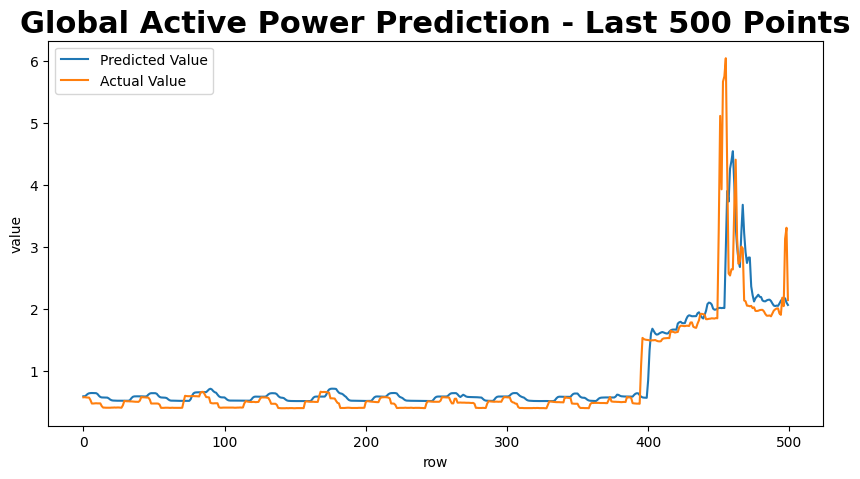

In [139]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: The LSTM model for the household dataset has performed reasonably well. From the plot , we can see that the predicted values closely follow the actual values for most of the data points, especially from row 0 to around row 400. However, there are noticeable deviations starting around row 400, with significant spikes observed towards rows 450 to 500. The Mean Squared Error (MSE) is approximately 0.3398. We can see th loss curves are smooth and decreasing, which is a good sign that the model is learning from the data and converge fairly fast. The smooth curve indicates that the model is not overfitting the training data. 
## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A: To improve the model performance, I will try the following changes:
1. Increase the number of hidden units in the LSTM layers to capture more complex patterns in the data.
2. Add more variables to the input sequences to provide more information to the model.
3. Change the optimizer to Adam and adjust the learning rate to improve convergence speed.
4. Increase the sequence length and predictive horizon to provide more context to the model.
5. Add more LSTM layers to capture deeper patterns in the data.

In [140]:
# Model
model_path = 'LSTM_model2-eval.keras'

nb_out = 1

model_2 = Sequential()


model_2.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=50,  # Increased units
         return_sequences=True))
model_2.add(Dropout(0.3))  # Increased dropout

# Add second LSTM layer with increased units
model_2.add(LSTM(
          units=25,  # Increased units
          return_sequences=True))
model_2.add(Dropout(0.3))  # Increased dropout

# Add third LSTM layer
model_2.add(LSTM(
          units=10,  # New LSTM layer
          return_sequences=False))
model_2.add(Dropout(0.3))  # Increased dropout

# Add final Dense layer
model_2.add(Dense(units=nb_out))
model_2.add(Activation('linear'))

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model_2.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

print(model_2.summary())

# Fit the network
history2 = model_2.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                     keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# List all data in history
print(history2.history.keys())


C:\Users\jegullin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 30, 25)         │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 30, 25)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 10)             │         1,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,451 (75.98 KB)

 Trainable params: 19,451 (75.98 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 43s - 1s/step - loss: 0.9765 - mse: 0.9955 - val_loss: 0.3027 - val_mse: 0.2516
Epoch 2/100
32/32 - 4s - 132ms/step - loss: 0.5685 - mse: 0.5795 - val_loss: 0.2842 - val_mse: 0.2325
Epoch 3/100
32/32 - 5s - 159ms/step - loss: 0.5335 - mse: 0.5379 - val_loss: 0.2953 - val_mse: 0.2458
Epoch 4/100
32/32 - 7s - 212ms/step - loss: 0.5487 - mse: 0.5363 - val_loss: 0.2790 - val_mse: 0.2292
Epoch 5/100
32/32 - 5s - 172ms/step - loss: 0.5019 - mse: 0.5100 - val_loss: 0.2750 - val_mse: 0.2249
Epoch 6/100
32/32 - 5s - 151ms/step - loss: 0.5024 - mse: 0.4994 - val_loss: 0.2946 - val_mse: 0.2441
Epoch 7/100
32/32 - 5s - 145ms/step - loss: 0.4868 - mse: 0.4953 - val_loss: 0.2674 - val_mse: 0.2193
Epoch 8/100
32/32 - 4s - 123ms/step - loss: 0.4817 - mse: 0.4850 - val_loss: 0.2784 - val_mse: 0.2286
Epoch 9/100
32/32 - 4s - 117ms/step - loss: 0.4686 - mse: 0.4759 - val_loss: 0.2803 - val_mse: 0.2307
Epoch 10/100
32/32 - 4s - 119ms/step - loss: 0.4830 - mse: 0.4815 - val_loss: 0

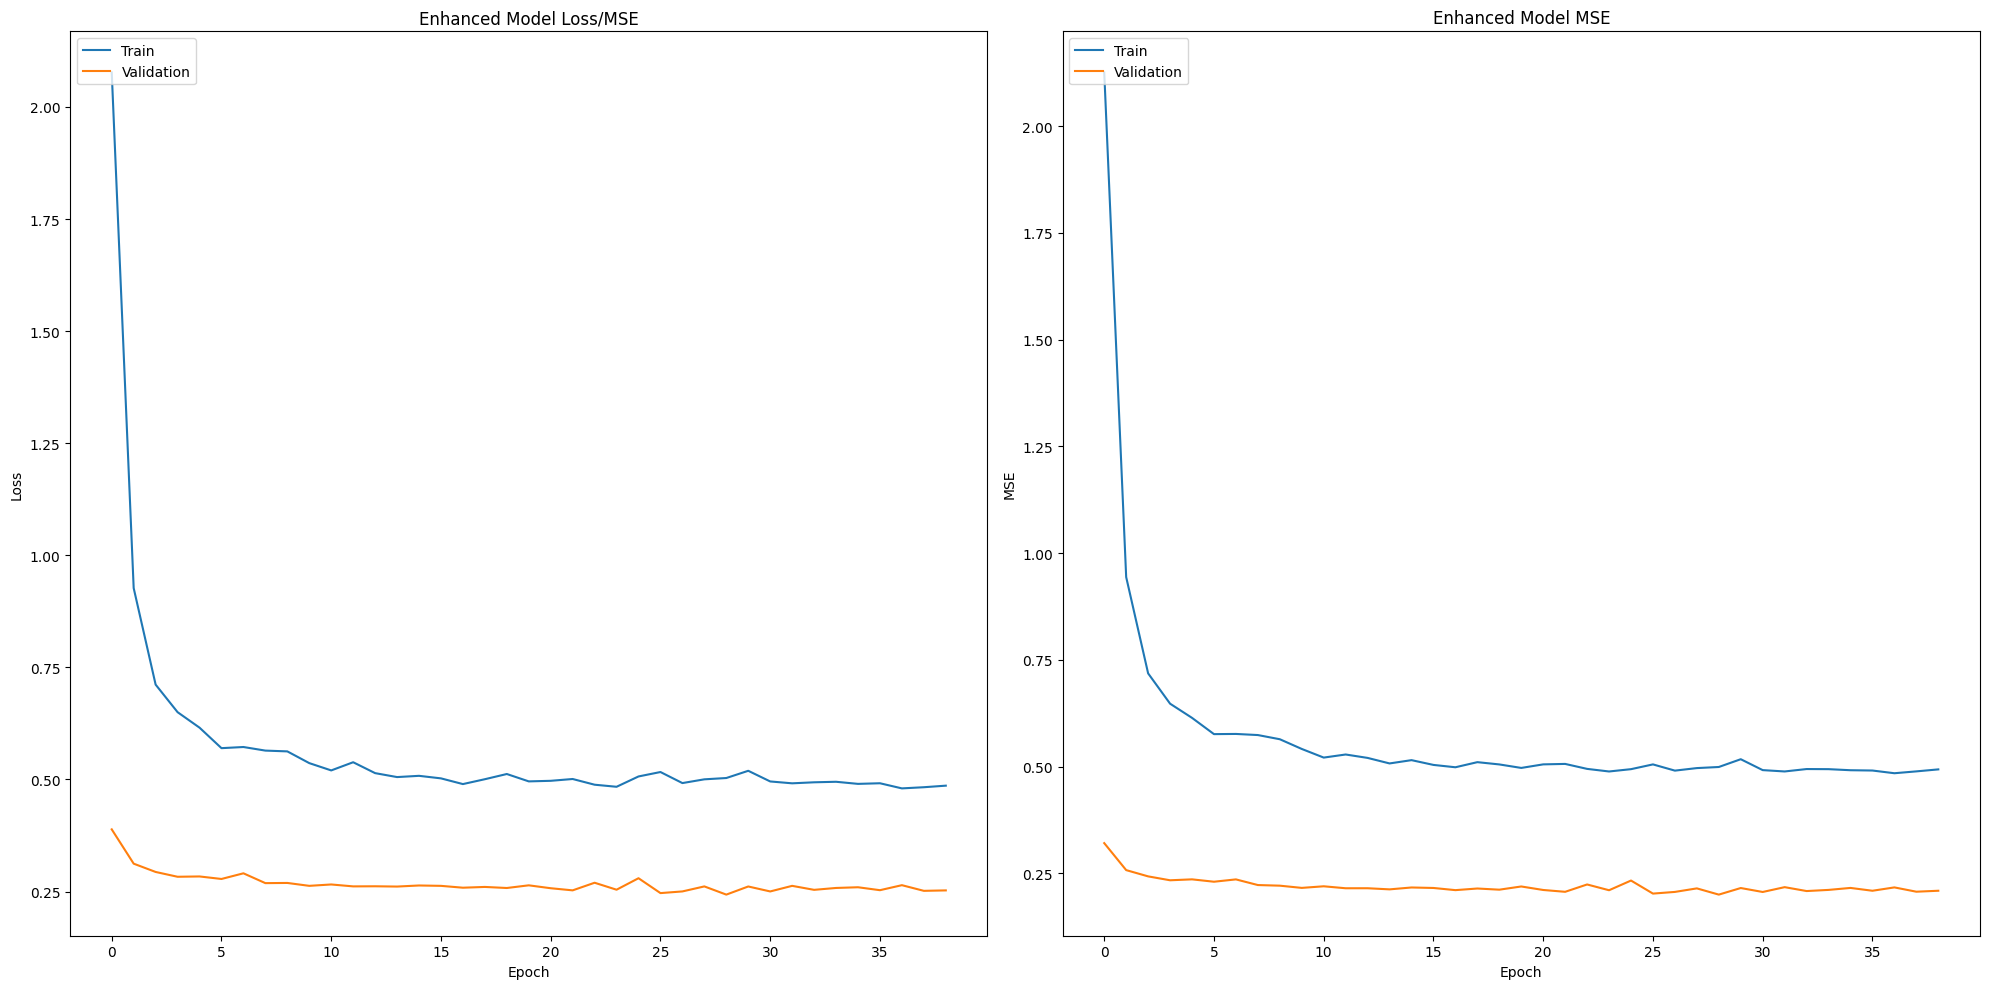

In [141]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Summarize history for Loss
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Enhanced Model Loss/MSE')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Summarize history for MSE
axes[1].plot(history.history['mse'])
axes[1].plot(history.history['val_mse'])
axes[1].set_title('Enhanced Model MSE')
axes[1].set_ylabel('MSE')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()


In [143]:
# MSE for the improved model
scores_test = model_2.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))


127/127 - 2s - 12ms/step - loss: 0.3462 - mse: 0.3462

MSE: 0.346197247505188


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


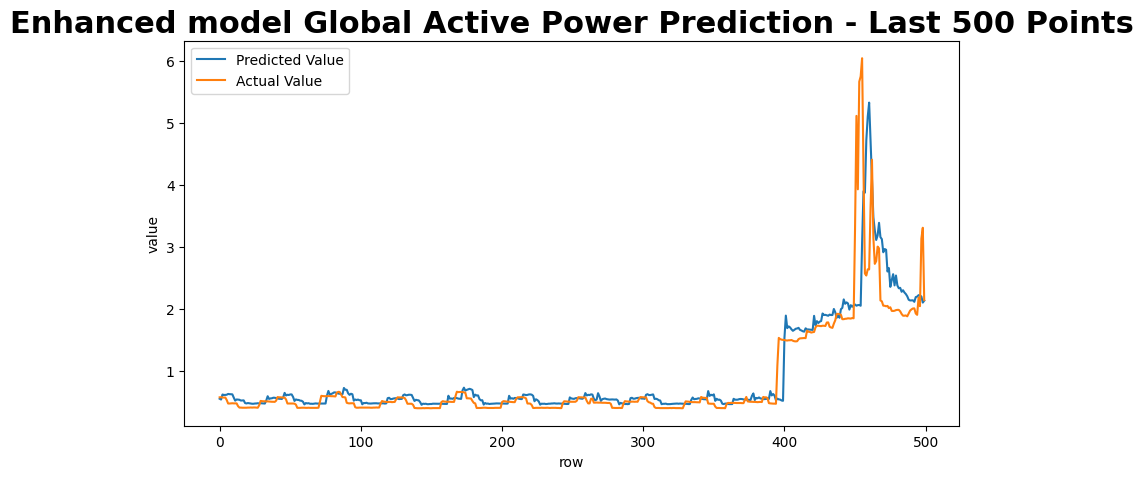

In [142]:
# Plot first 500 predictions for the improved model
y_pred_test_2 = model_2.predict(val_arrays)
y_true_test_2 = val_labs

fig_verify_2 = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test_2[-500:], label = 'Predicted Value')
plt.plot(y_true_test_2[-500:], label = 'Actual Value')
plt.title('Enhanced model Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: When Comparing both the models with the original model, the model original MSE: 0.33772796392440796 and MSE for optimized is MSE: 0.346197247505188. The optimized model did not perform as well as the original model. The changes made to the model may have introduced more complexity, which could have led to overfitting or other issues. This may indicate that the model is not generalizing well to the validation data. To optimize for production, I would try to simplify the model architecture, reduce the number of hidden units, or add more regularization to prevent overfitting. I would also experiment with different hyperparameters and model architectures to see if I can improve performance on the validation data. The next step would be to try different combinations of hyperparameters and model architectures to see if I can find a better-performing model.
**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: The LSTM model performed better than the linear regression model from last week in terms of Mean Squared Error (MSE). The LSTM model had an MSE of approximately 0.3398, while the linear regression model had higher MSE. The LSTM model is better suited for time series data like the household electricity consumption dataset, as it can capture temporal dependencies and patterns in the data. For an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, I would choose the LSTM model because it can provide more accurate predictions by taking into account the sequence of previous GAP readings. The LSTM model can also adapt to changing patterns in the data and make more accurate predictions over time. The linear regression model may not be able to capture the complex patterns in the data and may not perform as well as the LSTM model for this use case. In case if the simplier model is required, then linear regression model can be used.